In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/My Drive/lib')

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

import numpy as np
import matplotlib.pyplot as plt

import math



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
dataset = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_1.npy")
x = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_2.npy") 
dataset = np.concatenate((dataset,x),axis=0)
x = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_3.npy") 
dataset = np.concatenate((dataset,x),axis=0)

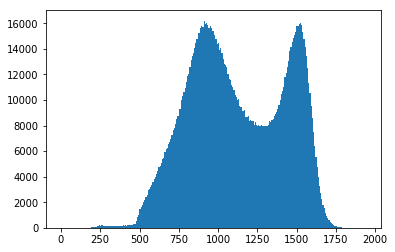

**** Display some sample values for reference: z=125; x=125; y=[125:140] 
raw:  [   0.       702.4829   827.6591   961.05835 1154.9955  1359.2179
 1464.9822  1397.3713  1203.547    966.5984   772.7163   686.564
  597.32086  538.85724  510.1532 ]
label:  [  0. 125. 125. 125. 125.  14.  14.  14.  14.  97.  97.  97.  97.  97.
  97.]
(373, 342, 342)
Total number of voxels in the Patient =  43627572
Total number of non-zero voxels =  1543898
Next is Image Equalization


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


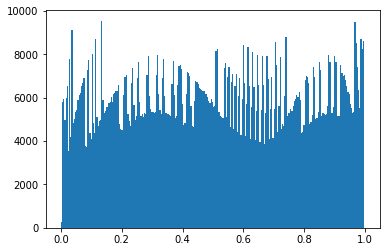

equalize:  [0.         0.07793374 0.1876256  0.36516523 0.5635231  0.70861965
 0.8131826  0.74016535 0.6004598  0.37090978 0.1339547  0.06968046
 0.02745098 0.01176471 0.00566974]
Number of patient (Length of dataset) =  15


In [3]:
import tensorflow as tf
import numpy as np
import random
import time
from numpy import array
import keras
import sys
import copy
import matplotlib.pyplot as plt

# The two functions for normalization are defined.
def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

def normalize(image):
    #Normalize the image 
    
    image = image.astype(np.float32)
    tmp = np.shape(image)
    print(tmp[0],tmp[1],tmp[2])
    #if image > 0:
    #  i_min = image.min()
    #  i_max = image.max()
    #  ret = (image - i_min) * 255/ (i_max - i_min)
    #else:
    #  ret = 0.     
      
  
    print("min ", np.min(image))
    print("max ", np.max(image))
    return image
  
  
def histeq(im,nbr_bins=256):
  """This is for image equalization"""
  #get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
   
  cdf = imhist.cumsum() #cumulative distribution function
  
  cdf_m = np.ma.masked_equal(cdf,0)#mask the background voxels 
    
  # the main step of histogram equalization
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) 
   
  cdf = np.ma.filled(cdf_m,0).astype('uint8') # set the removed background pixels back to 0

  #use linear interpolation of cdf to find new pixel values
    
  # im2 = np.interp(im.flatten(),bins[:-1],cdf)/255 # this line can cause the program to fail
  # ############################################## because it returns a float64 and run out of RAM
  im2 = (np.interp(im.flatten(),bins[:-1],cdf)/255).astype(np.float32)

  return im2.reshape(im.shape), cdf



# We load in three .npy files for training. Each file contains 5 patients.
#
"""
dataset = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_1.npy")
x = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_2.npy") 
dataset = np.concatenate((dataset,x),axis=0)
x = np.load("drive/My Drive/MRI_Brain_Segmentation/Dataset_final_3.npy") 
dataset = np.concatenate((dataset,x),axis=0)
"""

# padding to all sides of the 3D volume
npad = ((43,43), (43,43), (43,43))
for i in range (0, len(dataset)):  
  dataset[i][0] = np.pad(dataset[i][0], pad_width=npad, mode='constant', constant_values=0)
  dataset[i][1] = np.pad(dataset[i][1], pad_width=npad, mode='constant', constant_values=0)
  #
  #

  if i == 0: # Just for the first patient
    # plot histogram of the dataset raw values
    # Do not display the voxels at 0 for there are too many background voxels
    plt.hist(dataset[i][0].ravel(),256,[0.000001,np.amax(dataset[i][0])])
    plt.show()
    print("**** Display some sample values for reference: z=125; x=125; y=[125:140] ")
    print("raw: ",dataset[i][0][125][125][125:140])
    print("label: ",dataset[i][1][125][125][125:140])
    print(np.shape(dataset[i][0]))
    tmp_total = np.size(dataset[i][0])
    print("Total number of voxels in the Patient = ",tmp_total)
    # The following is to count the number of non-zero voxels in the raw values
    tmp_xyz=np.shape(dataset[i][0])
    countNZ = sum(sum(sum(dataset[i][0] != 0)))
    """
    countNZ = 0
    for ii in range(0,tmp_xyz[0]):
      for jj in range(0,tmp_xyz[1]):
        for kk in range(0,tmp_xyz[2]):
          if dataset[i][0][ii][jj][kk] != 0:
            countNZ += 1
    """
    print("Total number of non-zero voxels = ",countNZ)
    
    print("Next is Image Equalization")

  # Tp carry out image equalization
  dataset[i][0],_ = histeq(dataset[i][0])


  if i == 0: # Just for the first patient
    # Do not display the voxels at 0 for there are too many background voxels
    # Hence, the use of 0.000001
    plt.hist(dataset[i][0].ravel(),256,[0.000001,np.amax(dataset[i][0])])
    plt.show()
    print("equalize: ",dataset[i][0][125][125][125:140])
  #
    

  # dataset[i][0],_ = histeq(dataset[i][0])
  #tmp_data = copy.deepcopy(dataset[i][0])
  #dataset[i][0]=image_Norm(tmp_data)


print("Number of patient (Length of dataset) = ",len(dataset) )


In [0]:


"""
Residual Block
"""

def buildResBlock(inputs, layer_type='cv',
                  filter1=16, filter2=16, 
                  conv_size1=(3,3), conv_size2=(3,3), 
                  stride1=(1,1), stride2=(1,1), stridec=(2,2),
                  input_size_cross=False
                  ):
  
  if layer_type == 'cv':

    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter1, conv_size1, strides=stride1, padding='SAME')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter2, conv_size2, strides=stride2, padding='SAME')(x)
    
    if input_size_cross:
      ex = layers.Conv2D(filter2, (1,1), strides=stridec, padding='SAME')(inputs)
      x = layers.add([x, ex])
    else:
      x = layers.add([x, inputs])
      
    return x

  elif layer_type == 'cv3':

    x = layers.BatchNormalization()(inputs)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(filter1, conv_size1, strides=stride1, padding='SAME')(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv3D(filter2, conv_size2, strides=stride2, padding='SAME')(x)
    
    if input_size_cross:
      ex = layers.Conv3D(filter2, (1,1,1), strides=stridec, padding='SAME')(inputs)
      x = layers.add([x, ex])
    else:
      x = layers.add([x, inputs])
      
    return x
  
  else:
    print("Type Error")
    return None



In [0]:
from keras.utils import plot_model


In [34]:
def buildSingleResNetSmall():
  inputs = layers.Input(shape=(16,16,1))
  x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='SAME', activation='relu')(inputs)
  x = layers.MaxPooling2D((2, 2))(x)
  
  x = buildResBlock(inputs=x, layer_type='cv', filter1=128, filter2=128, stridec=(1,1), input_size_cross=True)
  x = buildResBlock(inputs=x, layer_type='cv', filter1=128, filter2=128)
  
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256, stride1=(2,2), input_size_cross=True)
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256)

  #x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256, stride1=(2,2), input_size_cross=True)
  #x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256)
  
  x = layers.AveragePooling2D((2, 2))(x)
  
  x = layers.Flatten()(x)
  
  network = models.Model(inputs=inputs, outputs=x)
  return network

  

def buildSingleResNetLarge():
  inputs = layers.Input(shape=(87,87,1))
  x = layers.Conv2D(64, (7, 7), strides=(3, 3), padding='VALID', activation='relu')(inputs)
  x = layers.MaxPooling2D((2, 2))(x)
  
  x = buildResBlock(inputs=x, layer_type='cv', filter1=128, filter2=128, stridec=(1,1), input_size_cross=True)
  x = buildResBlock(inputs=x, layer_type='cv', filter1=128, filter2=128)
  
  x = layers.MaxPooling2D((2, 2))(x)
  
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256, stride1=(2,2), input_size_cross=True)
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256)
  
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256, stride1=(2,2), input_size_cross=True)
  x = buildResBlock(inputs=x, layer_type='cv', filter1=256, filter2=256)
  
  x = layers.AveragePooling2D((2, 2))(x)
  
  x = layers.Flatten()(x)
  
  network = models.Model(inputs=inputs, outputs=x)
  return network

  

def buildSingleResNetCube():
  
  inputs = layers.Input(shape=(26,26,26,1))
  
  x = layers.Conv3D(64, (3, 3, 3), strides=(2, 2, 2), padding='SAME', activation='relu')(inputs)
  
  x = layers.MaxPooling3D((2, 2, 2))(x)
  
  
  x = buildResBlock(inputs=x, layer_type='cv3', conv_size1=(3,3,3), conv_size2=(3,3,3), 
                    filter1=128, filter2=128, stride1=(1,1,1), stride2=(1,1,1), stridec=(1,1,1), input_size_cross=True)
  
  x = buildResBlock(inputs=x, layer_type='cv3', conv_size1=(3,3,3), conv_size2=(3,3,3), 
                    filter1=128, filter2=128, stride1=(1,1,1), stride2=(1,1,1))

  
  x = buildResBlock(inputs=x, layer_type='cv3', conv_size1=(3,3,3), conv_size2=(3,3,3), 
                    filter1=256, filter2=256, stride1=(2,2,2), stride2=(1,1,1), stridec=(2,2,2), input_size_cross=True)
  
  x = buildResBlock(inputs=x, layer_type='cv3', conv_size1=(2,2,2), conv_size2=(2,2,2), 
                    filter1=256, filter2=256, stride1=(1,1,1), stride2=(1,1,1))
  

  
  x = layers.AveragePooling3D((2, 2, 2))(x)
  
  x = layers.Flatten()(x)
  
  network = models.Model(inputs=inputs, outputs=x)
  
  return network

  

res_cube = buildSingleResNetCube()
res_cube.summary()
plot_model(res_cube, to_file='drive/My Drive/MRI_Brain_Segmentation/resnet_diagram.png',show_shapes=True)

#res_small = buildSingleResNetSmall()
#res_small.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 26, 26, 26, 1 0                                            
__________________________________________________________________________________________________
conv3d_67 (Conv3D)              (None, 13, 13, 13, 6 1792        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_7 (MaxPooling3D)  (None, 6, 6, 6, 64)  0           conv3d_67[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 6, 6, 6, 64)  256         max_pooling3d_7[0][0]            
__________________________________________________________________________________________________
activation

In [35]:
def buildFullNetwork():
  #x1 = layers.Input(shape=(16,16,1))
  #x2 = layers.Input(shape=(87,87,1))
  #y1 = layers.Input(shape=(16,16,1))
  #y2 = layers.Input(shape=(87,87,1))
  #z1 = layers.Input(shape=(16,16,1))
  #z2 = layers.Input(shape=(87,87,1))
  cube = layers.Input(shape=(26,26,26,1))
  
  #x1_i = buildSingleResNetSmall()(x1)
  #x2_i = buildSingleResNetLarge()(x2)
  
  #y1_i = buildSingleResNetSmall()(y1)
  #y2_i = buildSingleResNetLarge()(y2)
  
  #z1_i = buildSingleResNetSmall()(z1)
  #z2_i = buildSingleResNetLarge()(z2)
  
  cube_i = buildSingleResNetCube()(cube)
  
  #x = layers.Concatenate()([x1_i, x2_i, y1_i, y2_i, z1_i, z2_i, cube_i])
  #x = layers.Concatenate()([x2_i, y2_i, z2_i])
  #x = layers.Concatenate()([x1_i, y1_i, z1_i])
  x = layers.Dropout(rate=0.5)(cube_i)
  #x = layers.Dense(270, activation='relu')(x)
  x = layers.Dense(135, activation='softmax')(x)

  #network = models.Model(inputs=[x1, y1, z1, x2, y2, z2, cube], outputs=x)
  #network = models.Model(inputs=[x2, y2, z2], outputs=x)
  #network = models.Model(inputs=[x1, y1, z1], outputs=x)
  network = models.Model(inputs=cube, outputs=x)
  return network

resnet = buildFullNetwork()
resnet.summary()
plot_model(resnet, to_file='drive/My Drive/MRI_Brain_Segmentation/resnet_diagram_highlv.png',show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 26, 26, 26, 1)     0         
_________________________________________________________________
model_13 (Model)             (None, 256)               5301120   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 135)               34695     
Total params: 5,335,815
Trainable params: 5,333,127
Non-trainable params: 2,688
_________________________________________________________________


In [0]:

adam = optimizers.Adam(lr=2e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
resnet.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])


In [17]:
# define the overall number of epochs per training session of 15 patients
T_epochs = 1
train_batch_size = 32
samples_size = 2000
vald_size = 200
test_size = samples_size - vald_size
samples_epochs = 1
total_voxel_sample = 1000000

weight_path = "drive/My Drive/MRI_Brain_Segmentation/resnet_cube_26_3.h5"

#reload weights that have been saved by the previous training session
#
#resnet.load_weights("drive/My Drive/MRI_Brain_Segmentation/resnet_cube_26_2.h5")
#
#print("Model Restored")
train_hist_acc = []
train_hist_val = []

print("Start Training")
stime = time.time()


try:
  for epoch in range(T_epochs):
      correct = 0
      iter = 0
      #define lists to append the data for training to vectorize the input
      
      t1=[] #small_x
      t2=[] #small_y
      t3=[] #small_z
      
      t4=[] #large_x
      t5=[] #large_y
      t6=[] #large_z
      
      t7=[] #volume
      t8=[] #ground truth
      
      
      for i in range(0,len(dataset)):
        #total number of elements in the image

        #print("\n Train Patient Number " + str(i))
        print("\n Train Loop Number " + str(i))
        #Sample 200,000 voxels in total from each patient.
        for j in range (0,total_voxel_sample):
          value = 0
          pat = random.randint(0,len(dataset)-1)
          total = np.size(dataset[pat][0])
          raw = dataset[pat][0]
          
          #only select non-background voxels for training
          while(value==0):
            voxel = random.randint(0,total-1)

            # before each image is 256x256, 
            # after padding 43, the new dimension is 342x342
            # find the voxel x,y,z values
            # z_layer is the slice number
            z_layer = (voxel//116964)
            row = (voxel%116964)//342
            col = (voxel%116964)%342
            value = dataset[pat][1][z_layer][row][col]
          
          
          #extract the 2D and 3D images needed for that pixel
          # small is 29x29; large is 87x87; volume is 13x13x13
          
          small_x = raw[z_layer, row-8:row+8,col-8:col+8]
          small_y = raw[z_layer-8:z_layer+8, row, col-8:col+8]
          small_z = raw[z_layer-8:z_layer+8, row-8:row+8, col]
          
          large_x = raw[z_layer, row-43:row+44,col-43:col+44]
          large_y = raw[z_layer-43:z_layer+44, row, col-43:col+44]
          large_z = raw[z_layer-43:z_layer+44, row-43:row+44, col]
          
          vol = raw[z_layer-13:z_layer+13,row-13:row+13,col-13:col+13]
          
          #reshape 
          
          small_x = np.reshape(small_x, (16,16,1))
          small_y = np.reshape(small_y, (16,16,1))
          small_z = np.reshape(small_z, (16,16,1))
          
          large_x = np.reshape(large_x, (87,87,1))
          large_y = np.reshape(large_y, (87,87,1))
          large_z = np.reshape(large_z, (87,87,1))
          
          vol = np.reshape(vol, (26,26,26,1))
          
          #one-hot encode the output value (label) for training
          # The range of value/label is [1,134]
          output = keras.utils.to_categorical(value, num_classes=135)
          
          #append the data to the list for training
          
          t1.append(small_x)
          t2.append(small_y)
          t3.append(small_z)
          
          t4.append(large_x)
          t5.append(large_y)
          t6.append(large_z)
          
          t7.append(vol)
          
          t8.append(output)
          
          #Collect and train every certain samples.
          if((j+1)%samples_size == 0):
            print(j+1, end=' ',flush=True)
            # train the model with the 5000 vectorized data. 
            # 4000 will be used for training and the remaining 1000 will be used
            # for validation 
            """
            resnet.fit([t1[0:4000],t2[0:4000],t3[0:4000],t4[0:4000],t5[0:4000],t6[0:4000],t7[0:4000]], [t8[0:4000]], 
                       epochs=1,batch_size=256,verbose=1, 
                       validation_data=([t1[4000:],t2[4000:],t3[4000:],t4[4000:],t5[4000:],t6[4000:],t7[4000:]], [t8[4000:]]))
            """
            x_train = np.array(t7)
            y_train = np.array(t8)
            
            #print(x_train.shape)
            #print(y_train.shape)
            
            h = resnet.fit(x_train[0:test_size], y_train[0:test_size], epochs=samples_epochs, batch_size=train_batch_size, verbose=1,
                           validation_data=([t7[test_size:]], [t8[test_size:]]))
            """
            resnet.fit([t1[0:test_size], t2[0:test_size], t3[0:test_size]], [t8[0:test_size]], 
                       epochs=samples_epochs,batch_size=train_batch_size,verbose=1, 
                       validation_data=([t1[test_size:], t2[test_size:], t3[test_size:]], [t8[test_size:]]))
            """
            train_hist_acc.append(h.history['acc'])
            train_hist_val.append(h.history['val_acc'])
            
            #reset the lists to accomodate the new 5000 samples.
            
            t1=[]
            t2=[]
            t3=[]
            
            t4=[]
            t5=[]
            t6=[]
            
            t7=[]
            
            t8=[]
        
        #Backup training weights after 1 patient
        resnet.save_weights(weight_path)
   
  #END of the 2 FOR loops 

  print("\n Training Completed: Time Taken %s s" % (time.time()-stime))

  print('Epoch', epoch+1, 'completed out of',T_epochs)

  #END of the 3 FOR loops 
  print("Training Complete and Saving Model with " + str(j+1) +" Iterations per patient")
  #Save weights after training completes
  resnet.save_weights(weight_path)
  print("Saved model to disk")

  print("All training completed !")

except KeyboardInterrupt:
  print("Training Interrupted Saving Model with " + str((j+1)) +" Iterations/patient")

Start Training

 Train Loop Number 0
2000 Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1303 - acc: 0.2006 - val_loss: 3.2339 - val_acc: 0.2700
4000 Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 2s 1ms/step - loss: 3.4869 - acc: 0.2556 - val_loss: 3.1562 - val_acc: 0.2650
6000 Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 2s 1ms/step - loss: 3.0896 - acc: 0.3239 - val_loss: 2.4580 - val_acc: 0.4000
8000 Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 3s 1ms/step - loss: 2.7437 - acc: 0.3800 - val_loss: 2.5945 - val_acc: 0.3750
10000 Train on 1800 samples, validate on 200 samples
Epoch 1/1
1800/1800 [==============================] - 2s 1ms/step - loss: 2.5125 - acc: 0.4211 - val_loss: 2.3571 - val_acc: 0.4050
12000 Train on 1800 samples, validate

In [18]:
len(train_hist_acc)

2600

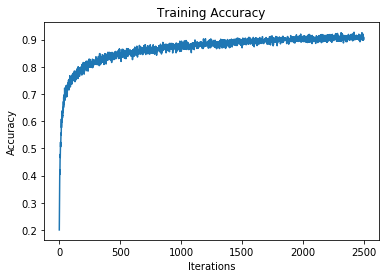

In [28]:
plt.plot(train_hist_acc[:2500])
plt.title("Training Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.savefig('drive/My Drive/MRI_Brain_Segmentation/train_acc.png', dpi=200)

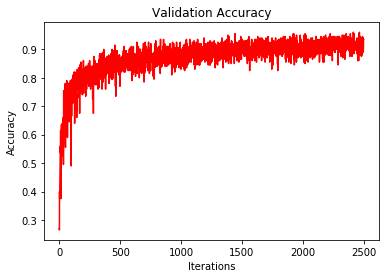

In [29]:
plt.plot(train_hist_val[:2500], 'r')
plt.title("Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.savefig('drive/My Drive/MRI_Brain_Segmentation/train_val_acc.png', dpi=200)

Testing Part


In [0]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/My Drive/lib')

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend

import numpy as np
import matplotlib.pyplot as plt

import math

from build_resnet import buildResBlock

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using TensorFlow backend.


In [0]:
import tensorflow as tf
import numpy as np
import random
import time
from numpy import array
import keras
import sys
import copy
import matplotlib.pyplot as plt


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret

def histeq(im,nbr_bins=256):
  """This is for image equalization"""
  #get image histogram
  imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
   
  cdf = imhist.cumsum() #cumulative distribution function
  
  cdf_m = np.ma.masked_equal(cdf,0)#mask the background voxels 
    
  # the main step of histogram equalization
  cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()) 
   
  cdf = np.ma.filled(cdf_m,0).astype('uint8') # set the removed background pixels back to 0

  #use linear interpolation of cdf to find new pixel values
    
  # im2 = np.interp(im.flatten(),bins[:-1],cdf)/255 # this line can cause the program to fail
  # ############################################## because it returns a float64 and run out of RAM
  im2 = (np.interp(im.flatten(),bins[:-1],cdf)/255).astype(np.float32)

  return im2.reshape(im.shape), cdf
  
  

#-------------------------------
# TESTING the trained network
#-------------------------------

#define the test file
# To carry out the testing one file at a time (with 5 patients)
path = "drive/My Drive/MRI_Brain_Segmentation/Dataset_final_test_1.npy"
#Load the Dataset 
dataset = np.load(path)

# READ in the test dataset, do the padding, and the two normalizations
# histeq returns two output items, and only the first output is needed,ignore the 2nd one.
# Normalize and Pad the Data (Preprocessing)
npad = ((43,43), (43,43), (43,43))
#
pred_labelimage = []  # Making a copy of the image for segmentation, 
            # at the end, it will be the label for each voxel
#
for i in range (0, len(dataset)):
  dataset[i][0] = np.pad(dataset[i][0], pad_width=npad, mode='constant', constant_values=0)
  dataset[i][1] = np.pad(dataset[i][1], pad_width=npad, mode='constant', constant_values=0)
  # Histogram equalization
  dataset[i][0], _ = histeq(dataset[i][0])
  
  #dataset[i][0] = whitening(dataset[i][0])
  
  #image.append(dataset[i][1])
  #print(image[i][180][180][145:160])
  print("resetting pred_labelimage[" + str(i) + "] to zero:")
  
  pred_labelimage.append(0*dataset[i][1])
  #print(pred_labelimage[i][180][180][145:160])
    
#Load the Ouput File
# image[0] is the first patient
print("pred_labelimage Shape is: ", pred_labelimage[0].shape)
print("pred_labelimage len is: ", len(pred_labelimage))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.


resetting pred_labelimage[0] to zero:
resetting pred_labelimage[1] to zero:
resetting pred_labelimage[2] to zero:
resetting pred_labelimage[3] to zero:
resetting pred_labelimage[4] to zero:
pred_labelimage Shape is:  (402, 342, 342)
pred_labelimage len is:  5


---------------------Start the Prediction: ------------------------
Test Patient Number 0
total number of voxels in the Patient =  47019528
To display one slice of the raw and label image first:


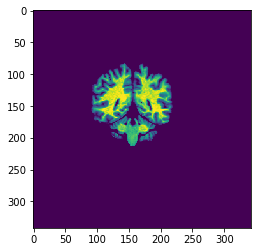

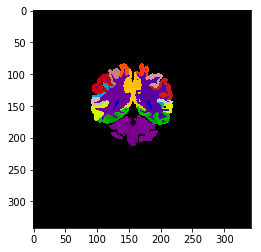

Iteration 12335394 Prediction: 1991/2000 samples correct (0.9955)
Iteration 12569020 Prediction: 1928/2000 samples correct (0.964)
Iteration 12799830 Prediction: 1484/2000 samples correct (0.742)
Iteration 12918871 Prediction: 622/2000 samples correct (0.311)
Iteration 13036178 Prediction: 1084/2000 samples correct (0.542)
Iteration 13151395 Prediction: 1449/2000 samples correct (0.7245)
Iteration 13264277 Prediction: 1456/2000 samples correct (0.728)
Iteration 13274898 Prediction: 1426/2000 samples correct (0.713)
Iteration 13385342 Prediction: 1628/2000 samples correct (0.814)
Iteration 13493763 Prediction: 1588/2000 samples correct (0.794)
Iteration 13504366 Prediction: 1562/2000 samples correct (0.781)
Iteration 13612121 Prediction: 1571/2000 samples correct (0.7855)
Iteration 13621990 Prediction: 1569/2000 samples correct (0.7845)
Iteration 13728740 Prediction: 1588/2000 samples correct (0.794)
Iteration 13737982 Prediction: 1616/2000 samples correct (0.808)
Iteration 13751312 Pre

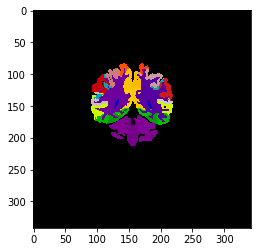

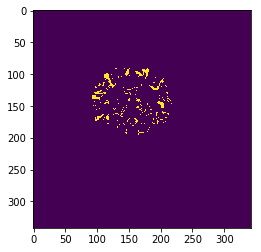

All the patients are completed !


In [0]:
import gc
import copy
import matplotlib.pyplot as plt

# To reload the model parameters

t1=[]
t2=[]
t3=[]
t4=[]
t5=[]
t6=[]
t7=[]
t8=[]
t9=[]
t10=[]
t11=[]

pred_samples_pool = 2000
pred_batch_size = 32

patient_start = 0
#patient_end = len(dataset)
patient_end = 1

print("---------------------Start the Prediction: ------------------------")
for i in range(patient_start,patient_end):   
  print("Test Patient Number " + str(i))
  total = np.size(dataset[i][0])
  print("total number of voxels in the Patient = ",total)
  # image[i] contains the labels of the dataset
  #true_labels = copy.deepcopy(image[i])  #this command is needed for making a clean copy
  true_labels = copy.deepcopy(dataset[i][1])
  #
  iter = 0
  correct = 0
  start = 0   #342*342*160            #0
  end = total #342*342*160 + 116964*5 #total
  raw = dataset[i][0]
  
  print("To display one slice of the raw and label image first:")
  # To show the raw image, slice 160
  plt.imshow(dataset[i][0][160])
  plt.show()
  # To show the label image, slice 160
  plt.imshow(dataset[i][1][160],cmap='nipy_spectral',interpolation='nearest')
  plt.show()
  
  start_time = time.time()
  # print("Starting recording test time for the patient")
  for j in range (start,end):
    stime = time.time()
    voxel = j
    # PREDICTION for every FIVE layers:
    # The IF statement to predict is carried out when
    # ( end of 5 layers OR coming to the last voxel )
    # 
    # Only predict if the voxel is non-zero within those 5 layers
    # 
    #if(((j+1)%(342*342*5)==0 or (j+1) == end) and len(t1)>0):
    if(len(t1)==pred_samples_pool or (j+1)==end):
      #
      # TO PREDICT/ CARRY OUT SEGMENTATION
      #pred = test.predict([t1,t4,t7])
      pred = resnet.predict([t7], batch_size=pred_batch_size)
      #pred = resnet.predict([t1, t2, t3], batch_size=pred_batch_size)
      
      
      # After prediction:
      # assign the prediction result to image, with the x,y,z locations
      #
      pred_labelimage[i][t9,t10,t11] = np.argmax(pred,axis=1)
      
      # compare between the pred result and the groundtruth (t8); #correct
      c = np.sum(np.equal(np.argmax(pred,axis=1),t8))
      correct += c
      
      print("Iteration " + str(j) + " Prediction: " + str(c) + "/" + str(len(t1)) + " samples correct (" + str(float(c)/len(t1)) + ")")
      
      # total number of voxels predicted is iter
      iter += len(np.equal(np.argmax(pred,axis=1),t8))
      
      # Clean up the array for the next round
      t1=[]
      t2=[]
      t3=[]
      t4=[]
      t5=[]
      t6=[]
      t7=[]
      t8=[]
      t9=[]
      t10=[]
      t11=[] 
      gc.collect()

    # 
    # TO APPEND data array for the next round of prediction
    # find the voxel x,y,z values
    z_layer = (voxel//116964)
    row = (voxel%116964)//342
    col = (voxel%116964)%342
    value = dataset[i][1][z_layer][row][col]
    # Here, we ignore and not append to data array if value = 0 (background voxel)
    if(value==0):
      continue
    else:
      # If the value is non-zero. we will extract the slice raw values for testing
      small_x = raw[z_layer][row-8:row+8,col-8:col+8]
      small_y = raw[z_layer-8:z_layer+8, row, col-8:col+8]
      small_z = raw[z_layer-8:z_layer+8, row-8:row+8, col]
      
      large_x = raw[z_layer, row-43:row+44, col-43:col+44]
      large_y = raw[z_layer-43:z_layer+44, row, col-43:col+44]
      large_z = raw[z_layer-43:z_layer+44, row-43:row+44, col]
      
      vol = raw[z_layer-13:z_layer+13,row-13:row+13,col-13:col+13]

      small_x = np.reshape(small_x, (16,16,1))
      small_y = np.reshape(small_y, (16,16,1))
      small_z = np.reshape(small_z, (16,16,1))
          
      large_x = np.reshape(large_x, (87,87,1))
      large_y = np.reshape(large_x, (87,87,1))
      large_z = np.reshape(large_x, (87,87,1))
      
      vol = np.reshape(vol, (26,26,26,1))

      t1.append(small_x)
      t2.append(small_y)
      t3.append(small_z)
        
      t4.append(large_x)
      t5.append(large_y)
      t6.append(large_z)
      
      t7.append(vol)
      
      t8.append(value)
      t9.append(z_layer)
      t10.append(row)
      t11.append(col)
    
  # When coming to here, the entire set of voxels has been completed
  print("Accuracy is: ",(correct/iter)*100," ; correct and iter are ",correct, iter ) 
  print("Time Taken for testing Patient: ", time.time()-start_time)
  
  # FINISHED testing and showing the accuracy of one patient 
  #
  # To show the predicated result of one slice (slice 160) from the CNN
  print("To display one slice of the predicted result and difference image :")
  plt.imshow(pred_labelimage[i][160],cmap='nipy_spectral',interpolation='nearest')
  plt.show()
  
  difference_mask = pred_labelimage[i][160] != true_labels[160]
  difference = difference_mask*true_labels[160]
  difference[difference>0] = 255 # make this area dark
   # To show the difference image
  plt.imshow(difference)
  plt.show()
  
  # Saving the result of just one slice to the folder
  np.save("drive/My Drive/MRI_Brain_Segmentation/Test_output_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",pred_labelimage[i][160])
  np.save("drive/My Drive/MRI_Brain_Segmentation/Test_raw_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",dataset[i][0][160][160])
  np.save("drive/My Drive/MRI_Brain_Segmentation/Test_label_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",dataset[i][1][160])
  np.save("drive/My Drive/MRI_Brain_Segmentation/Test_diff_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",difference)
  
  # Saving the result patient i to the folder
  np.save("drive/My Drive/MRI_Brain_Segmentation/Patient_output_" + str(i) + "_"+str(path[len(path)-5:-4])+ ".npy",pred_labelimage[i])
  # np.save("output_" + str(i) + "_"+str(path[len(path)-5:-4])+".npy",image[i])
print("All the patients are completed !")

